In [1]:
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from PIL import Image
import glob
from sklearn.decomposition import PCA
import pandas as pd
from sklearn import preprocessing 

from collections import OrderedDict
%matplotlib inline

### Load Image
***
* number_image : 3000
* image_list : array to store image , each row is a image.

In [3]:
image_path = 'C:/Users/user/Documents/ML/Homework3/Data/Data_Train/'
class_list = ['Class1','Class2','Class3']
image_list = []
for c in class_list:
    for filename in glob.glob(image_path+c+'/'+'*.bmp'): #assuming gif
        im=np.asarray(Image.open(filename))
        image_list.append(im)
image_list = np.asarray(image_list)
image_list = image_list.reshape(3000,-1)
number_image = len(image_list)


### PCA Data Preprocess
***
use library to do PCA , show the data in the two/three dimension space

In [4]:
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(image_list)
norm_data = preprocessing.scale(principalComponents)
# principalDf = pd.DataFrame(data = norm_data
#              , columns = ['principal component 1', 'principal component 2'])
color = np.zeros(3000)
color[:1000] = 1
color[1000:2000] = 2
color[2000:3000] = 3


t = np.zeros((len(image_list),3))
t[:1000,0] = 1
t[1000:2000,1] = 1
t[2000:3000,2] = 1



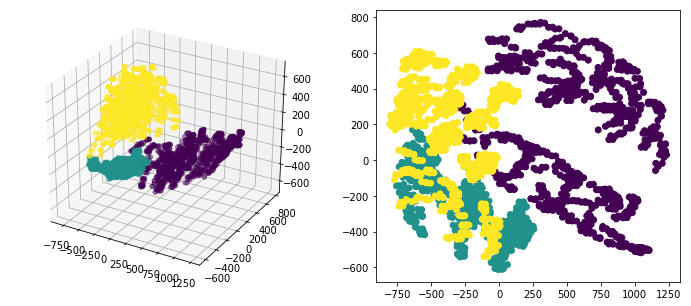

In [6]:
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(12)
ax = fig.add_subplot(121, projection='3d')

ax.scatter(principalComponents[:,0],principalComponents[:,1],principalComponents[:,2],c=color)
ax2 = fig.add_subplot(122)

ax2.scatter(principalComponents[:,0],principalComponents[:,1],c=color)

plt.show()

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(image_list)
norm_data = preprocessing.scale(principalComponents)

### Create randam number to Shuffle data
***
I divide the dataset into two part
* Train Dataset : 2000
* Test  Dataset : 1000

In [7]:
shuffle_idx = np.asarray(range(number_image))
np.random.shuffle(shuffle_idx)
x_train = norm_data[shuffle_idx[:2000]]
t_train = t[shuffle_idx[:2000]]
x_test = norm_data[shuffle_idx[2000:3000]]
t_test = t[shuffle_idx[2000:3000]]

### Define Function
***
* softmax(x)
* cross_entropy_eror(y,t)
    * y : predict label one hot encoding
    * t : ground truth one hot encoding


In [8]:
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) 
    return np.exp(x) / np.sum(np.exp(x))
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

### Define Layer
#### use graph method to perform forward and backward
***
* Relu()
* Sigmoid()
* Affine()
* SoftmaxWithLoss()


In [12]:
class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx
class Sigmoid:
    def __init__(self):
        self.out = None
    def sigmoid(self,x):
          return 1/(1+np.exp(-x))
    def forward(self, x):
        out = self.sigmoid(x)
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out

        return dx
    

class Affine:
    def __init__(self, W, b):
        self.W =W
        self.b = b
        
        self.x = None
        self.original_x_shape = None

        self.dW = None
        self.db = None
    def forward(self, x):

        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x

        out = np.dot(self.x, self.W) + self.b

        return out
    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        dx = dx.reshape(*self.original_x_shape)  
        return dx  
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None 
        self.t = None 

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size: 
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
        
        return dx

### Define Neual Network 
***
* TwoLayerNet : two layer neual network with Sigmoid activation
    * predict : get the prediction value without softmax
    * loss : forward all layer and return softmax loss
    * gradient :backward all layer and return weight/bias gradient

In [189]:
class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size) 
        self.params['b2'] = np.zeros(output_size)

        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Sigmoid'] = Sigmoid()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.lastLayer = SoftmaxWithLoss()
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
    def gradient(self, x, t):
        # forward
        self.loss(x, t)
        # backward
        dout = 1
        dout = self.lastLayer.backward(dout) 
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
        return grads
class ThreeLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, 5) 
        self.params['b2'] = np.zeros(5)
        self.params['W3'] = weight_init_std * np.random.randn(5, output_size) 
        self.params['b3'] = np.zeros(output_size)
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Sigmoid()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Sigmoid()
        self.layers['Affine3'] = Affine(self.params['W3'], self.params['b3'])        
        self.lastLayer = SoftmaxWithLoss()        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)        
        return x        
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy                
    def gradient(self, x, t):
        # forward
        self.loss(x, t)
        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
        grads['W3'], grads['b3'] = self.layers['Affine3'].dW, self.layers['Affine3'].db
        return grads    
class ThreeLayerNet_Relu:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, 5) 
        self.params['b2'] = np.zeros(5)
        self.params['W3'] = weight_init_std * np.random.randn(5, output_size) 
        self.params['b3'] = np.zeros(output_size)
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine3'] = Affine(self.params['W3'], self.params['b3'])        
        self.lastLayer = SoftmaxWithLoss()        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)        
        return x        
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy 
    def gradient(self, x, t):
        # forward
        self.loss(x, t)
        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
        grads['W3'], grads['b3'] = self.layers['Affine3'].dW, self.layers['Affine3'].db
        return grads

### Train Network
    

In [172]:
# Define all training policy 
iters_num = 5000
train_size = x_train.shape[0]
batch_size = 10
learning_rate = 0.01


# Loss Container to plot acc curve
train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

train_acc = []
test_acc = []

In [270]:
def train_net(network):
    global train_acc,test_acc,train_three
    train_acc = []
    test_acc = []
    for i in range(iters_num):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
        
        grad = network.gradient(x_batch, t_batch)
        
        # 更新
        if(train_three):
            for key in ('W1', 'b1', 'W2', 'b2','W3','b3'):
                network.params[key] -= learning_rate * grad[key]
        else:
            for key in ('W1', 'b1', 'W2', 'b2'):
                network.params[key] -= learning_rate * grad[key]
        
        loss = network.loss(x_batch, t_batch)
        train_loss_list.append(loss)
        
        if i % iter_per_epoch == 0:
            train_acc.append(network.accuracy(x_train, t_train))
            test_acc.append(network.accuracy(x_test, t_test))
            train_acc_list.append(train_acc)
            test_acc_list.append(test_acc)
    return network

def plot_learning(train_acc,test_acc):
    plt.plot(train_acc,label='train_acc')
    plt.plot(test_acc,label='test_acc')
    plt.legend()
    plt.show()
def plot_boundary(network):
    index_i = []
    index_j = []
    pred_list = []
    for i in np.linspace(-2,3,50):
        for j in np.linspace(-3,3,50):
            pred = np.argmax(network.predict(np.array([i,j]).reshape((1,-1))))
            pred_list.append(pred)
            index_i.append(i)
            index_j.append(j)
            
    return index_i,index_j,pred_list


### Two Layer Network 

In [355]:
train_three = False
iters_num = 5000
learning_rate = 0.01
network_two = TwoLayerNet(input_size=2, hidden_size=10, output_size=3)
network_two = train_net(network_two)
##plot_learning(train_acc,test_acc)
index_i,index_j,pred0  = plot_boundary(network_two)
print(train_acc[-1],test_acc[-1])
train_acc0 = train_acc.copy()
test_acc0 = test_acc.copy()

0.8335 0.818


### Three Layer Network 

In [273]:
train_three = True
iters_num = 5000
learning_rate = 0.01
network_three = ThreeLayerNet(input_size=2, hidden_size=10, output_size=3,weight_init_std=1)
network_three = train_net(network_three)
index_i,index_j,pred1  = plot_boundary(network_three)
print(train_acc[-1],test_acc[-1])

train_acc1 = train_acc.copy()
test_acc1 = test_acc.copy()

0.8615 0.853


### Three Layer Network Relu

In [274]:
train_three = True
iters_num = 5000
learning_rate = 0.01
network_three_relu = ThreeLayerNet_Relu(input_size=2, hidden_size=10, output_size=3,weight_init_std=1)
network_three_relu = train_net(network_three_relu)
index_i,index_j,pred2  = plot_boundary(network_three_relu)
print(train_acc[-1],test_acc[-1])

train_acc2 = train_acc.copy()
test_acc2 = test_acc.copy()

0.8855 0.881


### Plot the acc curve and dicision boundary
***
> I show it with interactive image chick on the tab to change 


* Acc curve show accuracy on test set
* Dicision Boundary show the hyperplane 

In [354]:
from bokeh.models.widgets import Panel, Tabs
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.layouts import row
output_notebook()
from bokeh.palettes import Pastel2 , Accent3
colormap = Pastel2[3]

colors_train = [colormap[x] for x in np.argmax(t_train,1)]
legend_acc = ['train','test']

##----------------------------------------------------------------------------------------
## PLOT FOR TWO LAYER NET
##----------------------------------------------------------------------------------------
colors = [colormap[x] for x in pred0]
p1 = figure(width=400,height=300)
p1.line(range(len(train_acc0)),
        train_acc0,
        line_color="firebrick",
        alpha=0.8,
        line_width=1,
        legend='train'
)
p1.line(range(len(test_acc0)),
        test_acc0,
        line_color="navy",
        alpha=0.8,
        line_width=1,
        legend='test'
)
p1.legend.location = "bottom_right"
s1 = figure(width=400,height=300)

s1.circle(index_i, 
          index_j, 
          size=4, 
          color=colors, 
          alpha=1,
          line_color=None
         
         )
s1.circle(x_train[:,0], 
          x_train[:,1],
          size=4, 
          color=colors_train, 
          alpha=1,
          line_color=None
         
         )
tab1 = Panel(child=row(p1,s1), title="Two Layer")
##----------------------------------------------------------------------------------------
## PLOT FOR THREE LAYER NET
##----------------------------------------------------------------------------------------
colors = [colormap[x] for x in pred1]
p2 = figure(width=400,height=300)
p2.line(range(len(train_acc1)),
        train_acc1,
        line_color="firebrick",
        alpha=0.8,
        line_width=1,
        legend='train'
)
p2.line(range(len(test_acc1)),
        test_acc1,
        line_color="navy",
        alpha=0.8,
        line_width=1,
        legend='test'
)
p2.legend.location = "bottom_right"

s2 = figure(width=400,height=300)

s2.circle(index_i, 
          index_j, 
          size=4, 
          color=colors, 
          alpha=1,
          line_color=None
         
         )
s2.circle(x_train[:,0], 
          x_train[:,1],
          size=4, 
          color=colors_train, 
          alpha=1,
          line_color=None
         
         )

tab2 = Panel(child=row(p2,s2), title="Three Layer")

##----------------------------------------------------------------------------------------
## PLOT FOR THREE RELU　LAYER NET
##----------------------------------------------------------------------------------------
colors = [colormap[x] for x in pred2]
p3 = figure(width=400,height=300)
p3.line(range(len(train_acc2)),
        train_acc2,
        line_color="firebrick",
        alpha=0.8,
        line_width=1,
        legend='train'
)
p3.line(range(len(test_acc2)),
        test_acc2,
        line_color="navy",
        alpha=0.8,
        line_width=1,
        legend='test'
)
p3.legend.location = "bottom_right"

s3 = figure(width=400,height=300)

s3.circle(index_i, 
          index_j, 
          size=4, 
          color=colors, 
          alpha=1,
          line_color=None
         
         )
s3.circle(x_train[:,0], 
          x_train[:,1],
          size=4, 
          color=colors_train, 
          alpha=1,
          line_color=None
         
         )


tab3 = Panel(child=row(p3,s3), title="Three Layer Relu")

tabs = Tabs(tabs=[ tab1, tab2 , tab3 ])
show(tabs)


Loading BokehJS ...